In [1]:
import numpy as np
# from numpy.lib.npyio import save
# np.set_printoptions(precision=5)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy as cp
import sys, json, pickle
PROJECT_PATHS = ['/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/', '/Users/noambuckman/mpc-multiple-vehicles/']
for p in PROJECT_PATHS:
    sys.path.append(p)
import src.traffic_world as tw
import src.multiagent_mpc as mpc
import src.car_plotting_multiple as cmplot
import src.solver_helper as helper
import src.vehicle as vehicle
import tqdm
import argparse, glob, os

plt.rcParams["font.family"] = "Times New Roman"

def check_ibr_exists(i_mpc, i_ibr, log_directory):
        file_name = log_directory + "data/"+'ibr_m%03di%03d'%(i_mpc, i_ibr)
        if os.path.isfile(file_name+"ambxamb.npy"):
            return True
        else:
            return False

def load_ibr_results(i_mpc, i_ibr, log_directory, params, executed=True):
    file_name = log_directory + "data/"+'ibr_m%03di%03d'%(i_mpc, i_ibr)
    n_other = params["n_other"]

    xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = mpc.load_state(file_name, n_other)
    if executed:
        n_exec = params["number_ctrl_pts_executed"]
        uamb_ibr = uamb_ibr[:, :n_exec]
        xamb_ibr = xamb_ibr[:, :n_exec+1]
        xamb_des_ibr = xamb_des_ibr[:, :n_exec+1]
        for j in range(len(all_other_x_ibr)):
            all_other_u_ibr[j] = all_other_u_ibr[j][:, :n_exec]
            all_other_x_ibr[j] = all_other_x_ibr[j][:, :n_exec+1]
            all_other_x_des_ibr[j] = all_other_x_des_ibr[j][:, :n_exec+1]
    return xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr

def tensorize(rounds_mpc, log_directory, params, executed=True):
    '''Generate a tensor whose size is [2, N, mpc, ibr] for a given agent
    executed: True: Only return control inputs that are executed
            False:  Return all control inputs generated during IBR
    '''
    if executed:
        N = params["number_ctrl_pts_executed"]
    else:
        N = params["N"]
        
    U = np.zeros(shape=(2, N, rounds_mpc, params["n_ibr"]))
    X = np.zeros(shape=(2, N+1, rounds_mpc, params["n_ibr"]))

    Uother = np.zeros(shape=(2, N, rounds_mpc, params["n_ibr"], params["n_other"]))
    Xother = np.zeros(shape=(2, N+1, rounds_mpc, params["n_ibr"], params["n_other"]))
    for i_mpc in tqdm.trange(rounds_mpc):
        for i_ibr in range(params["n_ibr"]):
            xamb_ibr, uamb_ibr, _, all_other_x_ibr, all_other_u_ibr, _ = load_ibr_results(i_mpc, i_ibr, log_directory, params, executed)
            U[:, :, i_mpc, i_ibr] = uamb_ibr
            X[:, :, i_mpc, i_ibr] = xamb_ibr[:2, :] #only pickout the XY
            for j in range(params["n_other"]):
                Uother[:, :, i_mpc, i_ibr, j] = all_other_u_ibr[j]
                Xother[:, :, i_mpc, i_ibr, j] = all_other_x_ibr[j][:2, :]

    
    return U, Uother, X, Xother


def closest_vehicles(X, Xother, n_agents, i_mpc):
    '''Return the indeces of the closest n_agents at beginning of round i_mpc'''
    
    X_repeated = np.repeat(X[:,:,:,:,np.newaxis], Xother.shape[-1], 4) #create a larger tensor of the ego positions
    deltaX = Xother - X_repeated
    deltaX0 = deltaX[:, 0, :, -1, :] # only keep the initial position of the ambulance, and last ibr
    sqdist = (deltaX0**2).sum(axis=0)
    list_of_veh_idxs = np.argsort(sqdist[i_mpc,:])
    list_of_veh_idxs = list_of_veh_idxs[:n_agents]

    return list_of_veh_idxs

def save_fig_custom(fig, name, image_format):
    if image_format == "all":
        img_formats = ["png", "svg", "pdf", "eps"]
    else:
        img_formats = [image_format]
        
    for img_format in img_formats:
        file_name = name + "." + img_format
        if os.path.isfile(file_name):
            os.remove(file_name)
        fig.savefig(file_name, transparent=True, bbox_inches='tight')
    return True

In [5]:
class Args:
    def __init__(self):
        self.i = 0
args = Args()
args.log_directories = ['/home/nbuckman/mpc_results/ibr_exps/2hbh-855b-20201025-135705/', 
                        '/home/nbuckman/mpc_results/ibr_exps/3f46-8h39-20201025-135721/', 
                        '/home/nbuckman/mpc_results/ibr_exps/8656-443a-20201025-135713/', 
                        '/home/nbuckman/mpc_results/ibr_exps/g756-798f-20201025-135729/', 
                        '/home/nbuckman/mpc_results/ibr_exps/ibr000/', 
                        '/home/nbuckman/mpc_results/ibr_exps/ibr001/', 
                        '/home/nbuckman/mpc_results/ibr_exps/ibr003/', 
                        '/home/nbuckman/mpc_results/ibr_exps/ibr005/']

args.start_mpc = 0
args.end_mpc = -1
args.image_format = "all"
args.n_agents = 6

args.figsave = False


In [6]:

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

delta0_norm_all_other = [list() for i in range(args.n_agents)]
delta0_norm_all = []

for lidx, log_directory in enumerate(args.log_directories):
    if args.end_mpc == -1:
        # Find the last run.  We currently assumes that all runs start from 0 and increment by 1
        list_of_mpc_data = glob.glob(log_directory + 'data/all_*xamb.npy')
        rounds_mpc = len(list_of_mpc_data)
        end_mpc = rounds_mpc - 1
    else:
        end_mpc = args.end_mpc
        rounds_mpc = end_mpc + 1

    with open(log_directory + "params.json",'rb') as fp:
        params = json.load(fp)
    # for k in params:
    #     print(k,": ", params[k])

    if not check_ibr_exists(0,0, log_directory):
        print("No IBR Exist for Directory %s"%log_directory)
        continue
    # xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = load_ibr_results(0, 0, log_directory, params)
    U, Uother, X, Xother = tensorize(rounds_mpc, log_directory, params)
    
    veh_idxs = closest_vehicles(X, Xother, args.n_agents, args.start_mpc)

    U = U[:, :, args.start_mpc:end_mpc, :]
    Uother = Uother[:, :, args.start_mpc:end_mpc, :, veh_idxs]

    # ## Defining Convergence Metric
    # 
    # $\delta(ibr) = \vec{u}_{mpc, ibr + 1} - \vec{u}_{mpc, ibr}$
    # which has dimensions
    # $ [2 x N] $
    # 
    for j in range(Uother.shape[-1]):
        delta_0 = np.diff(Uother[:, 0, 0,:, j], axis=1)
        ax1.plot(range(1, delta_0.shape[1]+1), delta_0[0, :])
    if lidx == 0:
        # ax1.set_title('Convergence of All Agents, Steering, $i_{mpc}=0$')
        ax1.set_xlabel("Rounds of Best Response")
        ax1.set_ylabel('$u^s_{t+1} - u^s_{t}$')
    # plt.show()
    save_fig_custom(fig1, log_directory + "plots/amb_conv_steering_i0", args.image_format)
    # plt.close()


    i_mpc = 0
    delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
    delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
    delta1_norm = np.linalg.norm(delta_U_mpc[1,:,:], axis=0)
    if lidx == 0:
        ax2.plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:], label="Norm delta over N steer cntrl")
        ax2.plot(range(1, delta0_norm.shape[0]+1), delta1_norm[:], label="Norm delta over N accel cntrl")
        # ax2.set_title("Convergence for Ambulance at $i_{mpc}$=0")
        ax2.set_xlabel("Rounds of Best Response")
        ax2.set_ylabel('$|u^s_{t+1} - u^s_{t}|, |u^a_{t+1} - u^a_{t}|$')    
        ax2.legend()        
    else:
        ax2.plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:], label=None)
        ax2.plot(range(1, delta0_norm.shape[0]+1), delta1_norm[:], label=None)

    # plt.show()

    save_fig_custom(fig2, log_directory + "plots/amb_both_ctrl_i0" , args.image_format)
    # plt.close()

    for i_mpc in range(U.shape[2]):
        delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
        delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
        delta0_norm_all += [delta0_norm]
        ax3.plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:])
    if lidx == 0:
        # ax3.set_title("Convergence of Ambulance's Steering @ Each Round of MPC")
        ax3.set_xlabel("Rounds of Best Response")
        ax3.set_ylabel("$|u^s_{t+1} - u^s_{t}|$")
    ax3.set_ylim([-.1, .1])
    # plt.show()
    save_fig_custom(fig3, log_directory + "plots/amb_convergence_steering", args.image_format)
    # plt.close()

    for i_mpc in range(U.shape[2]):
        delta_U_mpc = np.diff(U[:, :, i_mpc, :], axis=2)
        delta1_norm = np.linalg.norm(delta_U_mpc[1,:,:], axis=0)
        ax4.plot(range(1, delta1_norm.shape[0] + 1), delta1_norm[:])
    if lidx == 0:
        # ax4.set_title("Convergence of Ambulance's Steering @ Each Round of MPC")
        ax4.set_xlabel("Rounds of Best Response")
        ax4.set_ylabel("$|u^a_{t+1} - u^a_{t}|$")
    ax4.set_ylim([-.1, .1])

    # plt.show()
    save_fig_custom(fig4, log_directory + "plots/amb_convergence_acceleration" , args.image_format)

    # plt.close()

    grid_w = 3
    grid_h = int(np.ceil(Uother.shape[4] / 3))
    ## width height of each plot
    plot_w_i = 3
    plot_h_i = 3
    if lidx == 0:
        fig_w = plot_w_i * grid_w
        fig_h = plot_h_i * grid_h
        fig5, axs5 = plt.subplots(grid_h, grid_w, sharex=True, sharey=True, figsize=(fig_w, fig_h)) #w, h
        # fig5.suptitle("Steering Convergence for All Agents")
    for j in range(Uother.shape[4]):
        grid_i = j//grid_w
        grid_j = j%grid_w
    #     print(grid_i, grid_j)
        ag_id = veh_idxs[j] + 1  #In the paper, we index ado vehicles starting with 1
        axs5[grid_i, grid_j].set_title("Agent %d"%ag_id)
        for i_mpc in range(Uother.shape[2]):
            delta_U_mpc = np.diff(Uother[:, :, i_mpc, :, j], axis=2)
            delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
            delta0_norm_all_other[j] += [delta0_norm]

            axs5[grid_i, grid_j].plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:])
            axs5[grid_i, grid_j].set_xticks(range(1, delta0_norm.shape[0]+1))
    # plt.title("Convergence of Ambulance's Steering @ Each Round of MPC")

    # plt.xlabel("Rds of Best Response")
    # plt.ylabel("$|u^s_{t+1} - u^s_{t}|$")
    if lidx == 0:
        fig5.text(0.5, 0.00, 'Rounds of IBR', ha='center')
        fig5.text(0.0, 0.5, '$|\Delta_k(t)|$', va='center', rotation='vertical')
    # plt.show()
    plt.tight_layout()

    save_fig_custom(fig5, log_directory + "plots/" + "allagents_conv_steering" , args.image_format)

    # plt.close()


delta0_norm_all = np.array(delta0_norm_all)
# Dimensions:  n* X n_ibr
delta0_norm_avg = np.mean(delta0_norm_all, axis = 0)
delta0_norm_std = np.std(delta0_norm_all, axis = 0)
fig6, ax6 = plt.subplots()
d_ibr = range(1, delta0_norm_avg.shape[0] + 1)
ax6.plot(d_ibr, delta0_norm_avg)
plt.fill_between(d_ibr, delta0_norm_avg - delta0_norm_std, delta0_norm_avg + delta0_norm_std, alpha=0.25)
ax6.set_xlabel("Rounds of IBR", fontsize=12)
ax6.set_ylabel("$|\Delta_k|$", fontsize=12)

save_fig_custom(fig6, log_directory + "plots/" + "amb_avg_std_0" , args.image_format)

delta0_norm_50 = np.quantile(delta0_norm_all, .50, axis = 0)
delta0_norm_25 = np.quantile(delta0_norm_all, .25, axis = 0)
delta0_norm_75 = np.quantile(delta0_norm_all, .75, axis = 0)

golden_ratio = (5**.5 - 1) / 2
fig7, ax7 = plt.subplots(figsize=(3.5, 3.5*golden_ratio))
d_ibr = range(1, delta0_norm_50.shape[0] + 1)
ax7.plot(d_ibr, delta0_norm_50, color='red', label="Median")
plt.fill_between(d_ibr, delta0_norm_25, delta0_norm_75, alpha=0.25, color='red', label="25-75th Quantile")
ax7.set_xlabel("Rounds of IBR")
ax7.set_ylabel("$|\Delta_k|$")
plt.legend()
plt.tight_layout()
save_fig_custom(fig7, log_directory + "plots/" + "amb_med_iqr_0" , args.image_format)

# Repeat with all the agents


delta0_norm_all_other = np.array(delta0_norm_all_other) # nagents, n*, nibr
print(delta0_norm_all_other.shape)

grid_w = 3
grid_h = int(np.ceil(Uother.shape[4] / 3))
## width height of each plot
plot_w_i = 3
plot_h_i = 3
fig_w = plot_w_i * grid_w
fig_h = plot_h_i * grid_h

fig_w = 3.5
fig_h = 2* fig_w 
fig8, axs8 = plt.subplots(grid_h, grid_w, sharex=True, sharey=True, figsize=(fig_w, fig_h)) #w, h


# color=iter(cm.rainbow(np.linspace(0,1,delta0_norm_all_other.shape[0])))

colors = ['r','g','m', 'purple', 'orange', 'c']
for j in range(delta0_norm_all_other.shape[0]):

    grid_i = j//grid_w
    grid_j = j%grid_w
#     print(grid_i, grid_j)
    ag_id = veh_idxs[j] + 1
    axs8[grid_i, grid_j].set_title("Agent %d"%ag_id)
    # for i_mpc in range(Uother.shape[2]):
    #     delta_U_mpc = np.diff(Uother[:, :, i_mpc, :, j], axis=2)
    #     delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
    #     delta0_norm_all_other[j] += [delta0_norm]

    #     axs5[grid_i, grid_j].plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:])
    #     axs5[grid_i, grid_j].set_xticks(range(1, delta0_norm.shape[0]+1))
    delta0_norm_50 = np.quantile(delta0_norm_all_other[j, :, :], .50, axis = 0)
    delta0_norm_25 = np.quantile(delta0_norm_all_other[j, :, :], .25, axis = 0)
    delta0_norm_75 = np.quantile(delta0_norm_all_other[j, :, :], .75, axis = 0)
    c = colors[j%len(colors)]
    axs8[grid_i, grid_j].plot(range(1, delta0_norm_50.shape[0]+1), delta0_norm_50[:], color=c)
    axs8[grid_i, grid_j].fill_between(d_ibr, delta0_norm_25, delta0_norm_75, alpha=0.25, color=c, label="25-75th Quantile")

# fig7, ax7 = plt.subplots()
# d_ibr = range(1, delta0_norm_50.shape[0] + 1)
# ax7.plot(d_ibr, delta0_norm_50, color='red', label="Median")
fig8.text(0.5, 0.00, 'Rounds of IBR', ha='center')
fig8.text(0.0, 0.5, '$|\Delta_k|$', va='center', rotation='vertical')
# plt.legend()
plt.tight_layout()
save_fig_custom(fig8, log_directory + "plots/" + "other_med_iqr_0" , args.image_format)
print("Imgs Saved to...", log_directory + "plots/")


plt.close('all')

100%|██████████| 50/50 [00:05<00:00,  9.62it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 50/50 [00:05<00:00,  9.19it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 49/49 [00:05<00:00,  9.02it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 50/50 [00:05<00:00,  9.17it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support trans

(6, 387, 7)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Imgs Saved to... /home/nbuckman/mpc_results/ibr_exps/ibr005/plots/


# Plots Used In Paper

In [34]:
.9 * 3.5, .8*2.5

(2.8000000000000003, 2.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


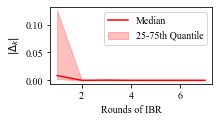

In [48]:
delta0_norm_50 = np.quantile(delta0_norm_all, .50, axis = 0)
delta0_norm_25 = np.quantile(delta0_norm_all, .25, axis = 0)
delta0_norm_75 = np.quantile(delta0_norm_all, .75, axis = 0)

golden_ratio = (5**.5 - 1) / 2
width_scale = 0.9
fig7, ax7 = plt.subplots(figsize=(width_scale * 3.5, width_scale * 2))
d_ibr = range(1, delta0_norm_50.shape[0] + 1)
ax7.plot(d_ibr, delta0_norm_50, color='red', label="Median")
plt.fill_between(d_ibr, delta0_norm_25, delta0_norm_75, alpha=0.25, color='red', label="25-75th Quantile")
ax7.set_xlabel("Rounds of IBR")
ax7.set_ylabel("$|\Delta_k|$")
plt.legend()
plt.tight_layout()
save_fig_custom(fig7, "/home/nbuckman/mpc_results/ibr_exps/all_plots/amb_med_iqr_0", args.image_format)

# save_fig_custom(fig7, log_directory + "plots/" + "amb_med_iqr_0" , args.image_format)
plt.show()
# Repeat with all the agents

(6, 387, 7)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Imgs Saved to... /home/nbuckman/mpc_results/ibr_exps/ibr005/plots/


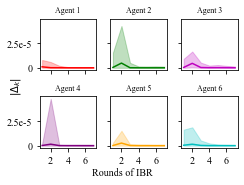

In [52]:


delta0_norm_all_other = np.array(delta0_norm_all_other) # nagents, n*, nibr
print(delta0_norm_all_other.shape)

grid_w = 3
grid_h = int(np.ceil(Uother.shape[4] / 3))
## width height of each plot
plot_w_i = 3
plot_h_i = 3
fig_w = plot_w_i * grid_w
fig_h = plot_h_i * grid_h

fig_w = 3.5
fig_h = 2.5
fig8, axs8 = plt.subplots(grid_h, grid_w, sharex=True, sharey=True, figsize=(fig_w, fig_h)) #w, h


# color=iter(cm.rainbow(np.linspace(0,1,delta0_norm_all_other.shape[0])))

colors = ['r','g','m', 'purple', 'orange', 'c']
for j in range(delta0_norm_all_other.shape[0]):

    grid_i = j//grid_w
    grid_j = j%grid_w
#     print(grid_i, grid_j)
    ag_id = veh_idxs[j] + 1
    axs8[grid_i, grid_j].set_title("Agent %d"%ag_id, fontsize=8)
    # for i_mpc in range(Uother.shape[2]):
    #     delta_U_mpc = np.diff(Uother[:, :, i_mpc, :, j], axis=2)
    #     delta0_norm = np.linalg.norm(delta_U_mpc[0,:,:], axis=0)
    #     delta0_norm_all_other[j] += [delta0_norm]

    #     axs5[grid_i, grid_j].plot(range(1, delta0_norm.shape[0]+1), delta0_norm[:])
    #     axs5[grid_i, grid_j].set_xticks(range(1, delta0_norm.shape[0]+1))
    delta0_norm_50 = np.quantile(delta0_norm_all_other[j, :, :], .50, axis = 0)
    delta0_norm_25 = np.quantile(delta0_norm_all_other[j, :, :], .25, axis = 0)
    delta0_norm_75 = np.quantile(delta0_norm_all_other[j, :, :], .75, axis = 0)
    c = colors[j%len(colors)]
    axs8[grid_i, grid_j].plot(range(1, delta0_norm_50.shape[0]+1), delta0_norm_50[:], color=c)
    axs8[grid_i, grid_j].fill_between(d_ibr, delta0_norm_25, delta0_norm_75, alpha=0.25, color=c, label="25-75th Quantile")
    axs8[grid_i, grid_j].set_xticks([2,4,6])
    axs8[grid_i, grid_j].set_yticks([0, 2.5e-5])
    axs8[grid_i, grid_j].set_yticklabels([0, "2.5e-5"])
    
# fig7, ax7 = plt.subplots()
# d_ibr = range(1, delta0_norm_50.shape[0] + 1)
# ax7.plot(d_ibr, delta0_norm_50, color='red', label="Median")
fig8.text(0.5, 0.00, 'Rounds of IBR', ha='center')
fig8.text(0.05, 0.5, '$|\Delta_k|$', va='center', rotation='vertical')
plt.tight_layout()

# plt.legend()?
save_fig_custom(fig8, "/home/nbuckman/mpc_results/ibr_exps/all_plots/other_med_iqr_0", args.image_format)
# plt.show()
print("Imgs Saved to...", log_directory + "plots/")